# Goal

* Analyze results from `atomIncorp_fracSize` simulation

# Var

In [1]:
workDir = '/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_fracSize/'

# Init

In [38]:
library(dplyr)
library(tidyr)
library(ggplot2)

as.Num = function(x) x %>% as.character %>% as.numeric

# Plotting fraction sizes

## Load

In [39]:
# files on simulation accuracy
files = list.files(path=workDir, pattern='fracs.txt', full.names=TRUE, recursive=TRUE)
files %>% length

[1] 240

In [40]:
df_fracs = list()
for (f in files){
    ff = strsplit(f, '/') %>% unlist
    df = read.delim(f, sep='\t')
    df$rep = ff[length(ff)-1]
    df$frac_mu = ff[length(ff)-2]
    df$atomIncorp = ff[length(ff)-3]
    df_fracs[[f]] = df
}

df_fracs = do.call(rbind, df_fracs)
rownames(df_fracs) = 1:nrow(df_fracs)

# status
df_fracs %>% dim %>% print
df_fracs %>% head(n=3)

[1] 31831     8


,library,fraction,BD_min,BD_max,fraction_size,rep,frac_mu,atomIncorp
1,1,1,1.673,1.676,0.003,1,0.003,0
2,1,2,1.676,1.678,0.002,1,0.003,0
3,1,3,1.678,1.679,0.001,1,0.003,0


## Fraction sizes

In [41]:
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

cat('Min BD:', min_BD, '\n')
cat('Max BD:', max_BD, '\n')

Min BD: 1.67323 
Max BD: 1.7744 


In [42]:
# filtering to just within min-max BD
df_fracs %>% nrow %>% print
df_fracs = df_fracs %>%
    filter(BD_min >= min_BD,
           BD_max <= max_BD)
df_fracs %>% nrow %>% print

[1] 31831
[1] 30391


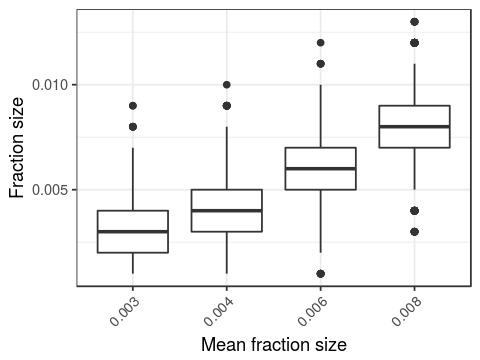

In [43]:
# plotting
options(repr.plot.width=4, repr.plot.height=3)
p_size = ggplot(df_fracs, aes(frac_mu, fraction_size)) +
    geom_boxplot() +
    labs(x='Mean fraction size', y='Fraction size') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )
plot(p_size)

## Number of fractions per gradient

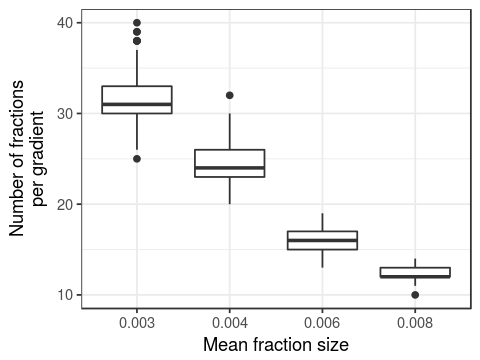

In [44]:
df_fracs_s = df_fracs %>%
    mutate(frac_mu = frac_mu %>% as.character) %>%
    group_by(library, rep, frac_mu, atomIncorp) %>%
    summarize(n_fracs = fraction %>% unique %>% length) %>%
    ungroup() %>%
    mutate(frac_mu = frac_mu %>% as.character) 

# plotting
options(repr.plot.width=4, repr.plot.height=3)
p_fracs = ggplot(df_fracs_s, aes(frac_mu, n_fracs)) +
    geom_boxplot() +
    labs(x='Mean fraction size', y='Number of fractions\nper gradient') +
    theme_bw() 
plot(p_fracs)

# Load

In [62]:
# files on simulation accuracy
files = list.files(path=workDir, pattern='*-cMtx_byClass.txt', full.names=TRUE)
files

[1] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_fracSize//DESeq2_multi-cMtx_byClass.txt"
[2] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_fracSize//DESeq2-cMtx_byClass.txt"      
[3] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_fracSize//heavy-cMtx_byClass.txt"       
[4] "/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/atomIncorp_fracSize//qSIP-cMtx_byClass.txt"

In [80]:
# combining files
df_byClass = list()
for (f in files){
    ff = strsplit(f, '/') %>% unlist
    fff = ff[length(ff)]
    df_byClass[[fff]] = read.delim(f, sep='\t')
}

df_byClass = do.call(rbind, df_byClass)
df_byClass$file = gsub('\\.[0-9]+$', '', rownames(df_byClass))
df_byClass$method = gsub('-.+', '', df_byClass$file)
rownames(df_byClass) = 1:nrow(df_byClass)

df_byClass %>% head(n=3)

,library,variables,values,percIncorp,frac_mu,rep,file,method
1,2,Sensitivity,NA,0,0.003,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi
2,2,Specificity,0.99908592321755,0,0.003,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi
3,2,Pos Pred Value,NA,0,0.003,1,DESeq2_multi-cMtx_byClass.txt,DESeq2_multi


In [81]:
# renaming methods
rename = data.frame(method = c('DESeq2', 'DESeq2_multi', 'heavy', 'qSIP'), 
                   method_new = c('HR-SIP', 'MW-HR-SIP', 'Heavy-SIP', 'q-SIP'))

df_byClass = inner_join(df_byClass, rename, c('method'='method')) %>%
    select(-method) %>%
    rename('method' = method_new) 

df_byClass %>% dim %>% print
df_byClass %>% head(n=3)

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining character vector and factor, coercing into character vector”

[1] 23040     8


,library,variables,values,percIncorp,frac_mu,rep,file,method
1,2,Sensitivity,NA,0,0.003,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP
2,2,Specificity,0.99908592321755,0,0.003,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP
3,2,Pos Pred Value,NA,0,0.003,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP


In [82]:
# adding number of fractions per gradient
## mean n-fracs
df_fracs_s = df_fracs %>%
    mutate(frac_mu = frac_mu %>% as.character) %>%
    group_by(library, rep, frac_mu, atomIncorp) %>%
    summarize(n_fracs = fraction %>% unique %>% length) %>%
    group_by(frac_mu) %>%
    summarize(n_fracs = mean(n_fracs)) %>%
    ungroup() %>%
    mutate(frac_mu = frac_mu %>% as.character) 

## joining
df_byClass = df_byClass %>%
    inner_join(df_fracs_s %>% 
                   dplyr::select(frac_mu, n_fracs) %>%
                   mutate(frac_mu = frac_mu %>% as.Num),
               c('frac_mu' = 'frac_mu'))

df_byClass %>% dim %>% print
df_byClass %>% head(n=3)

[1] 23040     9


,library,variables,values,percIncorp,frac_mu,rep,file,method,n_fracs
1,2,Sensitivity,NA,0,0.003,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP,31.4638888888889
2,2,Specificity,0.99908592321755,0,0.003,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP,31.4638888888889
3,2,Pos Pred Value,NA,0,0.003,1,DESeq2_multi-cMtx_byClass.txt,MW-HR-SIP,31.4638888888889


Warning message:
“Removed 64 rows containing missing values (geom_pointrange).”

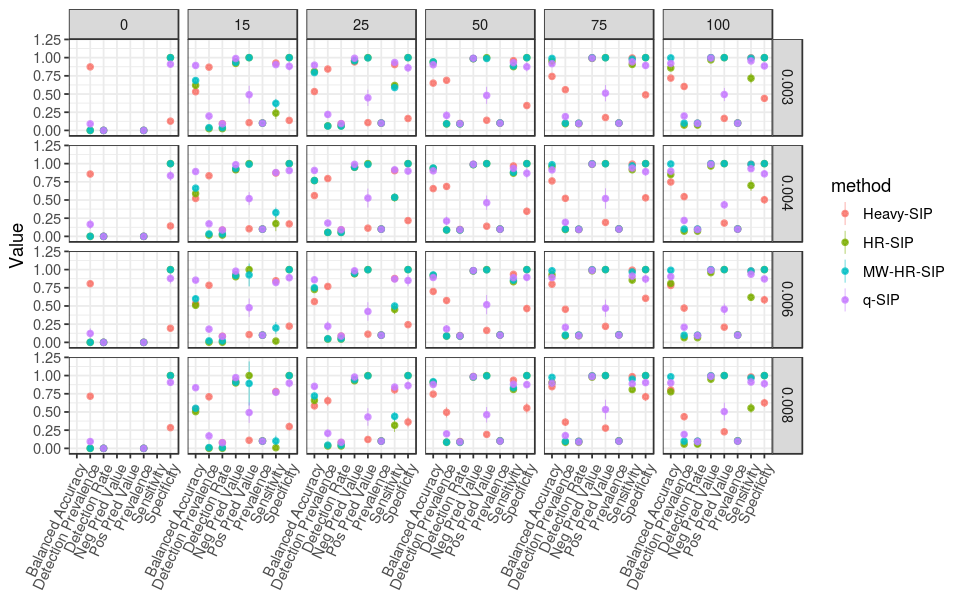

In [83]:
# summarize by SIPSim rep & library rep
df_byClass.s = df_byClass %>%
    group_by(method, percIncorp, frac_mu, n_fracs, variables) %>%
    summarize(mean_value = mean(values, na.rm=TRUE),
              sd_value = sd(values, na.rm=TRUE))

# plotting
options(repr.plot.width=8, repr.plot.height=5)
p = ggplot(df_byClass.s, aes(variables, mean_value, color=method,
                         ymin=mean_value-sd_value,
                         ymax=mean_value+sd_value)) +
    geom_pointrange(alpha=0.8, size=0.2) +
    labs(y='Value') +
    facet_grid(frac_mu ~ percIncorp) +
    theme_bw() +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=65, hjust=1)
    )
plot(p)

Warning message:
“Removed 32 rows containing missing values (geom_point).”Warning message:
“Removed 32 rows containing missing values (geom_linerange).”Warning message:
“Removed 4 rows containing missing values (geom_path).”

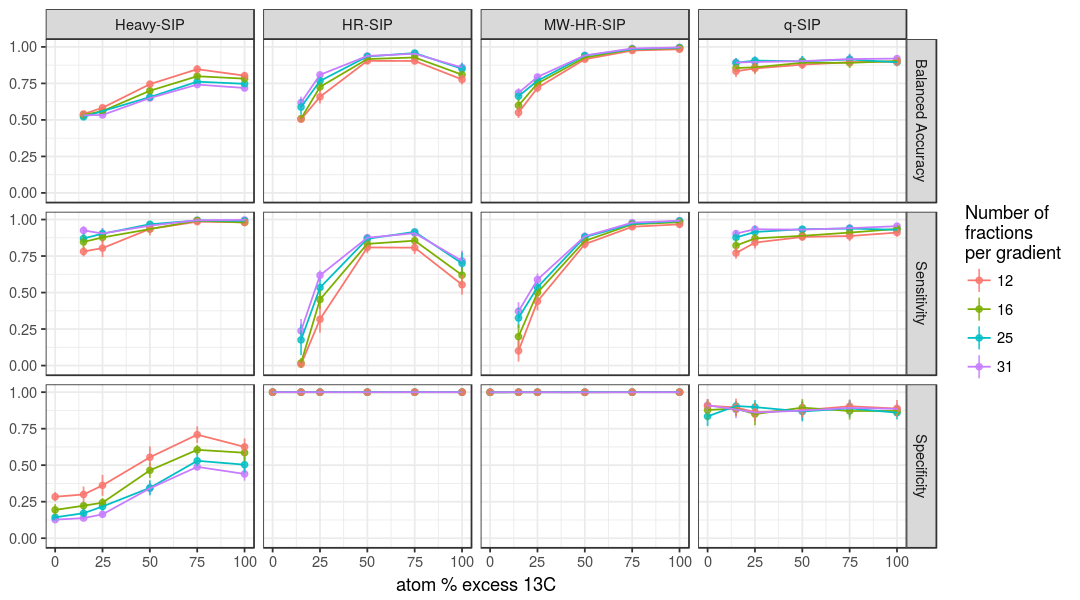

In [84]:
# summarize by SIPSim rep & library rep
vars = c('Balanced Accuracy', 'Sensitivity', 'Specificity')
df_byClass.s.f = df_byClass.s %>%
    filter(variables %in% vars) %>%
    ungroup() %>%
    mutate(frac_mu = frac_mu %>% as.character,
           frac_mu = frac_mu %>% reorder(frac_mu %>% as.Num),
           n_fracs = round(n_fracs, 0) %>% as.character,
           n_fracs = n_fracs %>% reorder(n_fracs %>% as.Num))


# plotting
options(repr.plot.width=9, repr.plot.height=5)
p.pnt = ggplot(df_byClass.s.f, aes(percIncorp, mean_value, 
                           color=n_fracs, 
                           group=n_fracs,
                           ymin=mean_value-sd_value,
                           ymax=mean_value+sd_value)) +
    geom_point(alpha=0.8) +
    geom_linerange(alpha=0.8, size=0.5) +
    geom_line() +
    scale_color_discrete('Number of\nfractions\nper gradient') +
    labs(x='atom % excess 13C') +
    facet_grid(variables ~ method) +
    theme_bw() +
    theme(
        axis.title.y = element_blank()
    )
plot(p.pnt)